In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, average_precision_score,
    recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import cross_val_score, train_test_split

import IPython
from IPython.display import Audio, display
os.environ['NUMBA_CACHE_DIR'] = IPython.paths.get_ipython_cache_dir()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get the user's home directory (e.g., 'C:\Users\user')
DATA_DIR = r"C:\Users\ferit\MLPC2025_classification"
metadata_dir = os.path.join(DATA_DIR, 'metadata.csv')
features_dir = os.path.join(DATA_DIR, 'audio_features')
labels_dir = os.path.join(DATA_DIR, 'labels')

#### Load Metadata

In [3]:
# Load Metadata & Training Files
metadata = pd.read_csv(metadata_dir)
train_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()

#### Load categories

In [4]:
# Select a random audio file and its annotations
np.random.seed(1)
sample_file = np.random.choice(metadata['filename'].tolist())

# Load corresponding label file
label_filename = sample_file.replace('.mp3', '_labels.npz')
label_path = os.path.join(DATA_DIR, 'labels', label_filename)
labels = np.load(label_path)

# Load categories
categories = list(labels.keys())
print("Names of Label Classes: \n", categories)

Names of Label Classes: 
 ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow', 'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip', 'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh', 'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill', 'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat', 'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck', 'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']


#### Aggregate Labels

In [5]:
# Aggregate Labels
def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if(sum(frame_labels) == 0):
            __y.append([0])
        elif(np.count_nonzero(frame_labels) == len(frame_labels)):
             __y.append([1])
        else: #The annotators don't agree on the label
            __y.append([np.random.choice(frame_labels)])
    return __y

### Split Train Data

#### Read Files

In [6]:
# Read files and split train data
import itertools
def read_files(file_names, num_to_read=(len(train_files))):
    X_train = []
    Y_train = {}
    for c in categories:
        Y_train[c] = []
    for f in file_names[:num_to_read]:
        if not os.path.exists(os.path.join(features_dir , f.split('.')[0] + '.npz')):
            continue
        features = np.load(os.path.join(features_dir , f.split('.')[0] + '.npz'))["embeddings"]
        X_train.append(features)
        y = np.load(os.path.join(labels_dir , f.split('.')[0] + '_labels.npz'))
        for c in categories:
            _y = aggregate_labels(y[c])
            Y_train[c].extend(list(itertools.chain.from_iterable(_y)))
    X_train = np.concatenate(X_train)
    return X_train, Y_train

#### Split data without data leakage

In [7]:
# Split data without data leakage
train_files, test_files = train_test_split(metadata["filename"].unique(), test_size=0.3, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=1/3, random_state=42)
#So final split: 70% train, 20% val, 10% test

# Print number of train, validation and test files
print("Number of train files      :",len(train_files))
print("Number of validation files :",len(val_files))
print("Number of test files       :",len(test_files))

Number of train files      : 5761
Number of validation files : 1646
Number of test files       : 823


#### Load train & test data

In [8]:
# High computational effort!!!

In [9]:
# Load train & test data (full)
X_train_raw, Y_train = read_files(train_files)
X_val_raw, Y_val = read_files(val_files)
X_test_raw, Y_test = read_files(test_files)

# print raw feature tensor shapes
print("Train shapes      (raw):", X_train_raw.shape, len(Y_train))
print("Validation shapes (raw):", X_val_raw.shape, len(Y_val))
print("Test shapes       (raw):", X_test_raw.shape, len(Y_test))

Train shapes      (raw): (1077406, 768) 58
Validation shapes (raw): (306418, 768) 58
Test shapes       (raw): (154753, 768) 58


### Apply Feature Normalization & PCA dimensionality reduction (with 90% explained variance)

#### Feature Tensor Scaler

In [10]:
from sklearn.preprocessing import StandardScaler

# Compute scaling parameters ONLY on training data
scaler = StandardScaler().fit(X_train_raw)

#### Scale & Normalize Feature Tensor

In [11]:
# Scale Train and Test Feature Tensor
X_train_scaled = scaler.transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)
X_test_scaled = scaler.transform(X_test_raw)

# print scaled feature tensor shapes
print("Train shapes      (scaled):", X_train_scaled.shape, len(Y_train))
print("Validation shapes (scaled):", X_val_scaled.shape, len(Y_val))
print("Test shapes       (scaled):", X_test_scaled.shape, len(Y_test))

del X_train_raw, X_val_raw, X_test_raw

Train shapes      (scaled): (1077406, 768) 58
Validation shapes (scaled): (306418, 768) 58
Test shapes       (scaled): (154753, 768) 58


#### Dimensionality reduction for Feature Tensor with PCA

In [12]:
from sklearn.decomposition import PCA

# PCA dimensionality reduction with keeping 90% of the variance
pca = PCA(n_components=0.9)
X_train = pca.fit_transform(X_train_scaled) # fit and transform train feature tensor
X_val = pca.transform(X_val_scaled)         # transform validation feature tensor
X_test = pca.transform(X_test_scaled)       # transform test feature tensor

# print reduced feature tensor shapes
print("Train shapes      (reduced):", X_train.shape, len(Y_train))
print("Validation shapes (reduced):", X_val.shape, len(Y_val))
print("Test shapes       (reduced):", X_test.shape, len(Y_test))

del X_train_scaled, X_val_scaled, X_test_scaled

Train shapes      (reduced): (1077406, 122) 58
Validation shapes (reduced): (306418, 122) 58
Test shapes       (reduced): (154753, 122) 58


### Training Evaluation

#### Class labels for Multi-Classification

In [13]:
# Multi-class labels
Y_train_multi = np.array([Y_train[cls] for cls in categories]).T
Y_val_multi = np.array([Y_val[cls] for cls in categories]).T
Y_test_multi = np.array([Y_test[cls] for cls in categories]).T

# print multi-class label class shapes
print("Train labels:      ", len(Y_train_multi))
print("Validation labels: ", len(Y_val_multi))
print("Test labels:       ", len(Y_test_multi))

del Y_train, Y_val, Y_test

Train labels:       1077406
Validation labels:  306418
Test labels:        154753


#### Macro-Averaged Balanced Accuracy Metric

In [14]:
from sklearn.metrics import balanced_accuracy_score

# Macro-Averaged Balanced Accuracy
def balanced_accuracy(Y_valid, Y_pred):
    # Ensure arrays are 2D (reshape if 1D)
    if Y_valid.ndim == 1:
        Y_valid = Y_valid.reshape(-1, 1)
    if Y_pred.ndim == 1:
        Y_pred = Y_pred.reshape(-1, 1)
        
    n_labels = Y_valid.shape[1]
    balanced_accuracies = []
    
    for i in range(n_labels):
        score = balanced_accuracy_score(Y_valid[:, i], Y_pred[:, i])
        balanced_accuracies.append(score)
    
    # Macro-average across labels
    balanced_accuracy_macro = np.mean(balanced_accuracies)
    
    print(f"Macro-Averaged Balanced Accuracy: {balanced_accuracy_macro:.2f}")

#### Multi-Neural Network Classifier

#### CUDA availability check

In [15]:
import torch
print("CUDA version:",torch.version.cuda)

# CUDA availability check
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

CUDA version: 12.8
Using GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


#### Convert data to tensor

In [16]:
from torch.utils.data import TensorDataset, DataLoader
start_time = time.time()

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
Y_train_tensor = torch.FloatTensor(Y_train_multi).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
Y_val_tensor = torch.FloatTensor(Y_val_multi).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
Y_test_tensor = torch.FloatTensor(Y_test_multi).to(device)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### MultiLabel NN Classifier

In [17]:
# Neural Network Classifier
import torch
import torch.nn as nn

class MultiLabelNN(nn.Module):
    def __init__(self, input_size, hidden_size=512,output_size=58):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.8)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.layer1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.layer2(x)))
        x = self.dropout(x)
        return self.output(x)

#### Initialize NN model

In [18]:
import torch.optim as optim

# Initialize model
input_size = X_train.shape[1]
output_size = len(categories)
model = MultiLabelNN(input_size=input_size, output_size=output_size).to(device)

# Calculate class weights (handle imbalance)
pos_weights = (1 / (Y_train_tensor.mean(dim=0) + 1e-8)).clamp(min=1.0, max=10.0)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights, reduction='mean')

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.25)

#### Train & Validate Neural Network Model

In [19]:
def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50, patience=5):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(epochs):
        
        # Training
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        # LR scheduling
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), 'multi_nn_model.pth')
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if (epoch+1) % 5 == 0:
            print(f'Epoch {epoch+1:3}/{epochs:3}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

    # Load best model
    model.load_state_dict(torch.load('multi_nn_model.pth'))
    return train_losses, val_losses

In [20]:
# Train Multi NN model
start_time = time.time()
train_losses, val_losses = train_model_with_validation(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    epochs=100, 
    patience=10
)
end_time = time.time()

# Print training time
total_seconds = end_time - start_time
hours = int(total_seconds // 3600)
remaining_seconds = total_seconds % 3600
minutes = int(remaining_seconds // 60)
seconds = remaining_seconds % 60
print(f"\nTraining completed in: {hours}h {minutes}m {seconds:.0f}s")

Epoch   5/100, Train Loss: 0.2210, Val Loss: 0.1975, LR: 0.001000
Epoch  10/100, Train Loss: 0.2210, Val Loss: 0.1987, LR: 0.001000
Epoch  15/100, Train Loss: 0.2049, Val Loss: 0.1891, LR: 0.000250
Epoch  20/100, Train Loss: 0.1988, Val Loss: 0.1879, LR: 0.000250
Epoch  25/100, Train Loss: 0.1982, Val Loss: 0.1867, LR: 0.000250
Epoch  30/100, Train Loss: 0.1980, Val Loss: 0.1864, LR: 0.000250
Epoch  35/100, Train Loss: 0.1978, Val Loss: 0.1867, LR: 0.000250
Epoch  40/100, Train Loss: 0.1975, Val Loss: 0.1861, LR: 0.000250
Epoch  45/100, Train Loss: 0.1878, Val Loss: 0.1840, LR: 0.000063
Epoch  50/100, Train Loss: 0.1872, Val Loss: 0.1832, LR: 0.000063
Epoch  55/100, Train Loss: 0.1870, Val Loss: 0.1830, LR: 0.000063
Epoch  60/100, Train Loss: 0.1869, Val Loss: 0.1834, LR: 0.000063
Epoch  65/100, Train Loss: 0.1832, Val Loss: 0.1818, LR: 0.000016
Epoch  70/100, Train Loss: 0.1830, Val Loss: 0.1823, LR: 0.000016
Early stopping at epoch 75

Training completed in: 0h 26m 48s


#### Plot Learning Curves

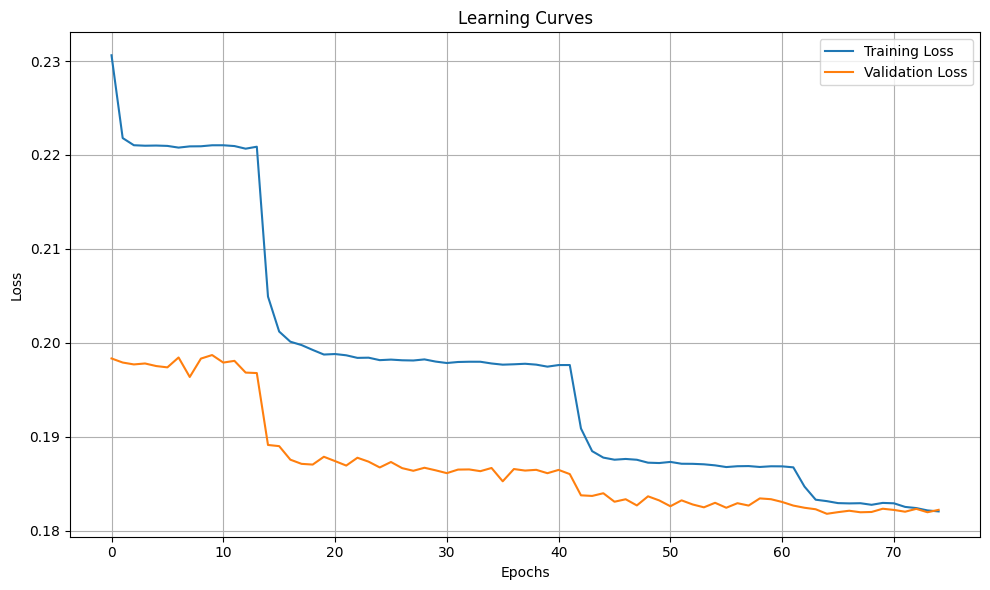

In [21]:
# plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('MultiNN_training_learning_curve.png')
plt.show()

In [22]:
# Load best model
model.load_state_dict(torch.load('multi_nn_model.pth'))

<All keys matched successfully>

In [23]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            y_true.append(labels.cpu())
            y_pred.append(preds.cpu())
    
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    return y_true, y_pred

#### MultiLabel NN Performance Metrics

In [24]:
# Predict on test set
Y_test_multi, Y_test_pred = evaluate_model(model, test_loader)

# Neural Network Performance Metrics 
print("\nPerformance Metrics - Multilabel Neural Network Classifier")
print("=" * 60)
multi_nn_perf = balanced_accuracy(Y_test_multi, Y_test_pred)


Performance Metrics - Multilabel Neural Network Classifier
Macro-Averaged Balanced Accuracy: 0.74


### Analyse Prediction on Test Files

 #### Label class frequency (Test Files)

In [25]:
# Filter metadata for test files only
metadata = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
test_metadata = metadata[metadata['filename'].isin(test_files)].copy()

# Label class frequency
label_counts = {}
file_class_counts = []
for filename in test_metadata['filename']:
    label_file = filename.replace('.mp3', '_labels.npz')
    label_path = os.path.join(DATA_DIR, 'labels', label_file)
    with np.load(label_path) as data:
        
        # Count distinct label classes per file
        active_classes = [cls for cls in data.keys() if data[cls].sum() > 0]
        file_class_counts.append(len(active_classes))
        
        # Check how many files have each class label
        for cls in data.keys():
            if np.any(data[cls] > 0):  # Check if class is active
                label_counts[cls] = label_counts.get(cls, 0) + 1

# add distinct classes per file into metadata
test_metadata['distinct_classes'] = file_class_counts

#### Plot label class frequency (Test Files)

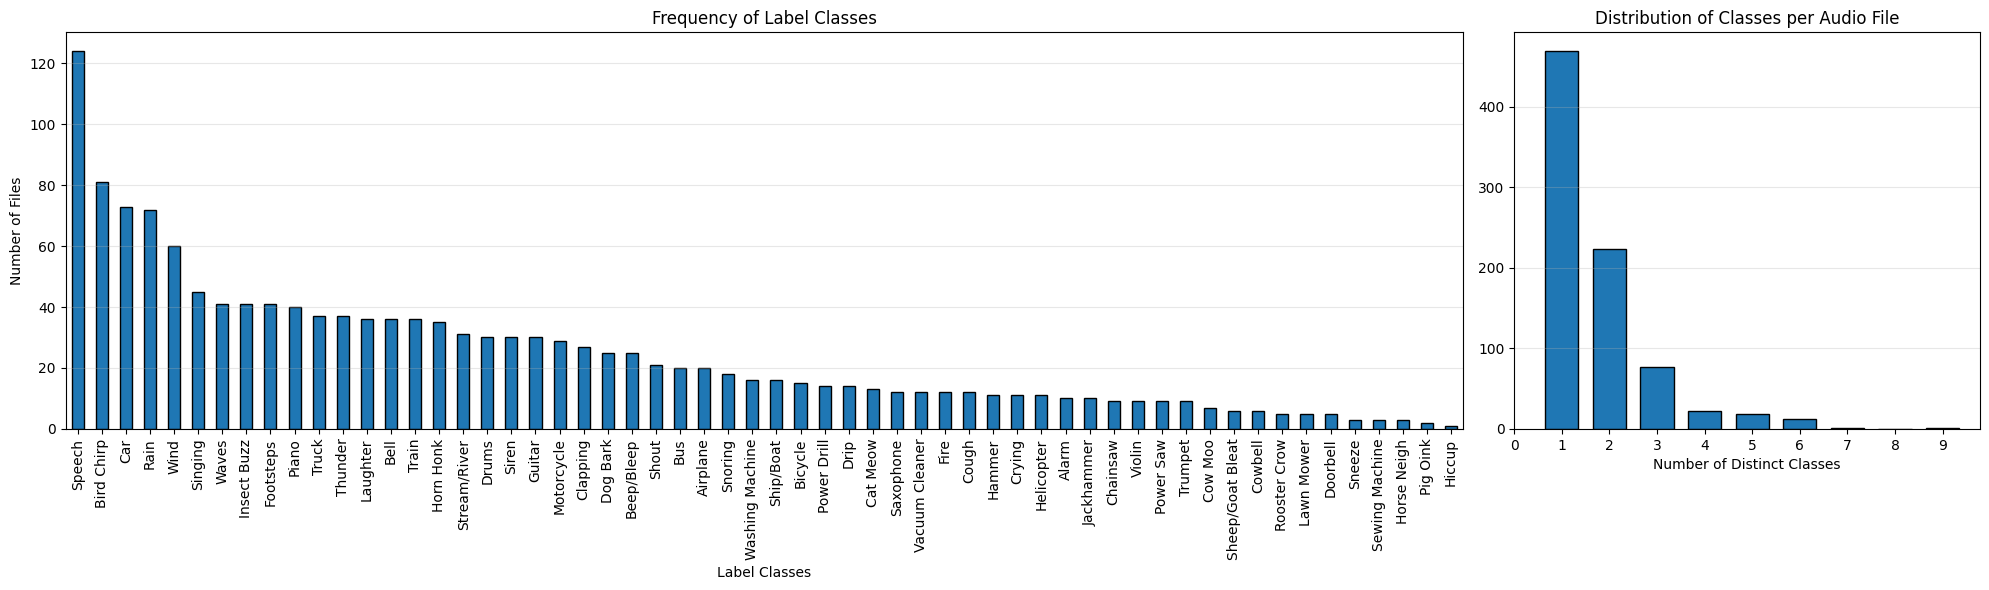

In [26]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

# Plot label class frequency
plt.subplot(gs[0])
pd.Series(label_counts).sort_values(ascending=False).plot(kind='bar', edgecolor='black')
plt.title('Frequency of Label Classes')
plt.xlabel('Label Classes')
plt.ylabel('Number of Files')
plt.grid(axis='y', alpha=0.3)

# Plot distribution of classes per file
plt.subplot(gs[1])
plt.hist(file_class_counts, bins=np.arange(0, max(file_class_counts)+1) + 0.5, 
         edgecolor='black', rwidth=0.7)
plt.title('Distribution of Classes per Audio File')
plt.xlabel('Number of Distinct Classes')
plt.xticks(range(0, max(file_class_counts)+1))
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save the figure
plt.savefig('test_files_class_distribution.png')
plt.show()

#### Print files with most and least diverse label classes

In [27]:
# Show top most/least diverse files
N = 1

print("\n=== Top Most Diverse File ===")
most_diverse_files = test_metadata.nlargest(N, 'distinct_classes')[['filename', 'distinct_classes']]
print(most_diverse_files.to_string(index=False))

print("\n=== Top Least Diverse File ===")
least_diverse_files = test_metadata.nsmallest(N, 'distinct_classes')[['filename', 'distinct_classes']]
print(least_diverse_files.to_string(index=False))


=== Top Most Diverse File ===
  filename  distinct_classes
451478.mp3                 9

=== Top Least Diverse File ===
  filename  distinct_classes
668922.mp3                 1


#### Print annotations of most diverse label classes

In [28]:
# Print annotations of most diverse label classes
print("Print annotations of most diverse label classes")
print("=" * 80)

for sample_file in most_diverse_files.head(1)['filename']:
    file_to_play = os.path.join(DATA_DIR, "audio", sample_file)

    # print sample file name
    print(f"Playing '{sample_file}':")
    with np.load(os.path.join(DATA_DIR, 'labels', sample_file.replace('.mp3', '_labels.npz'))) as data:
        
        # print active classes in sample file
        active_classes = [cls for cls in data.keys() if data[cls].sum() > 0]
        print("Active classes:", sorted(set(active_classes)),"\n")

    # Load annotations 
    annotations = pd.read_csv(os.path.join(DATA_DIR, "annotations.csv"))

    # print annotations in sample file
    file_annotations = annotations[annotations['filename'] == sample_file].sort_values('onset')
    print(f"Number of annotations: {len(file_annotations)}")
    print(file_annotations[['onset', 'offset', 'text', 'categories']].head(len(file_annotations)))

Print annotations of most diverse label classes
Playing '451478.mp3':
Active classes: ['Bird Chirp', 'Bus', 'Car', 'Horn Honk', 'Insect Buzz', 'Motorcycle', 'Speech', 'Train', 'Truck'] 

Number of annotations: 9
           onset     offset                                              text  \
13799   0.000000  27.649000               Birds chirping in the far distance.   
13801   0.000000  27.649000            People are chatting in the background.   
13800   0.050104  27.649000  Vehicles driving by on a moderately busy street.   
13802   0.764085   1.365332                            A sharp buzzing noise.   
13803   1.402910   2.780768                A car horn sounds in the distance.   
13804  10.233728  15.807790              A train passes by in the background.   
13805  16.922603  17.411116                 A car is honking in the distance.   
13806  21.983100  27.649000     An announcer speaks in the distance, muffled.   
13807  25.916258  26.367194                 A car is honkin

#### Visualize the classifier's predictions

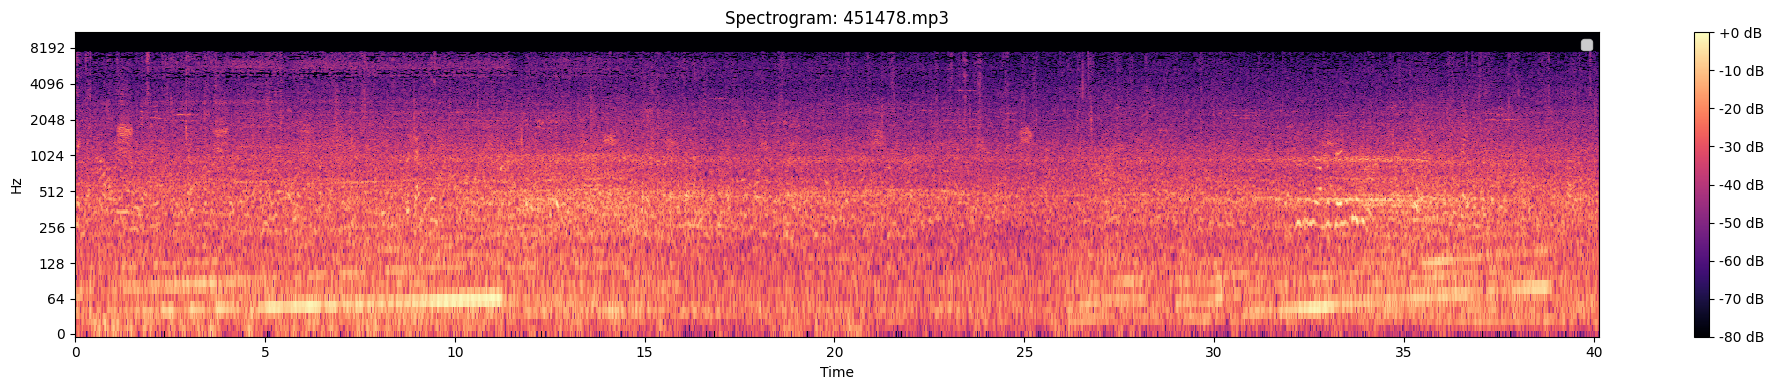

In [30]:
import librosa
import librosa.display

# Choose the most diverse file
sample_file = most_diverse_files['filename'].iloc[0]
file_to_play = os.path.join(DATA_DIR, "audio", sample_file)

# Load audio and create spectrogram
y, sr = librosa.load(file_to_play, sr=None)
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)

# Create figure
plt.figure(figsize=(20, 4))
librosa.display.specshow(D, y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram: {sample_file}')
plt.tight_layout()
plt.savefig(f'spectrogram_{sample_file}_most_label_classes.png')
plt.show()

In [31]:
# Play audio with predictions
print("Playing full audio with prediction highlights:")
display(Audio(y, rate=sr, autoplay=False))

Playing full audio with prediction highlights:


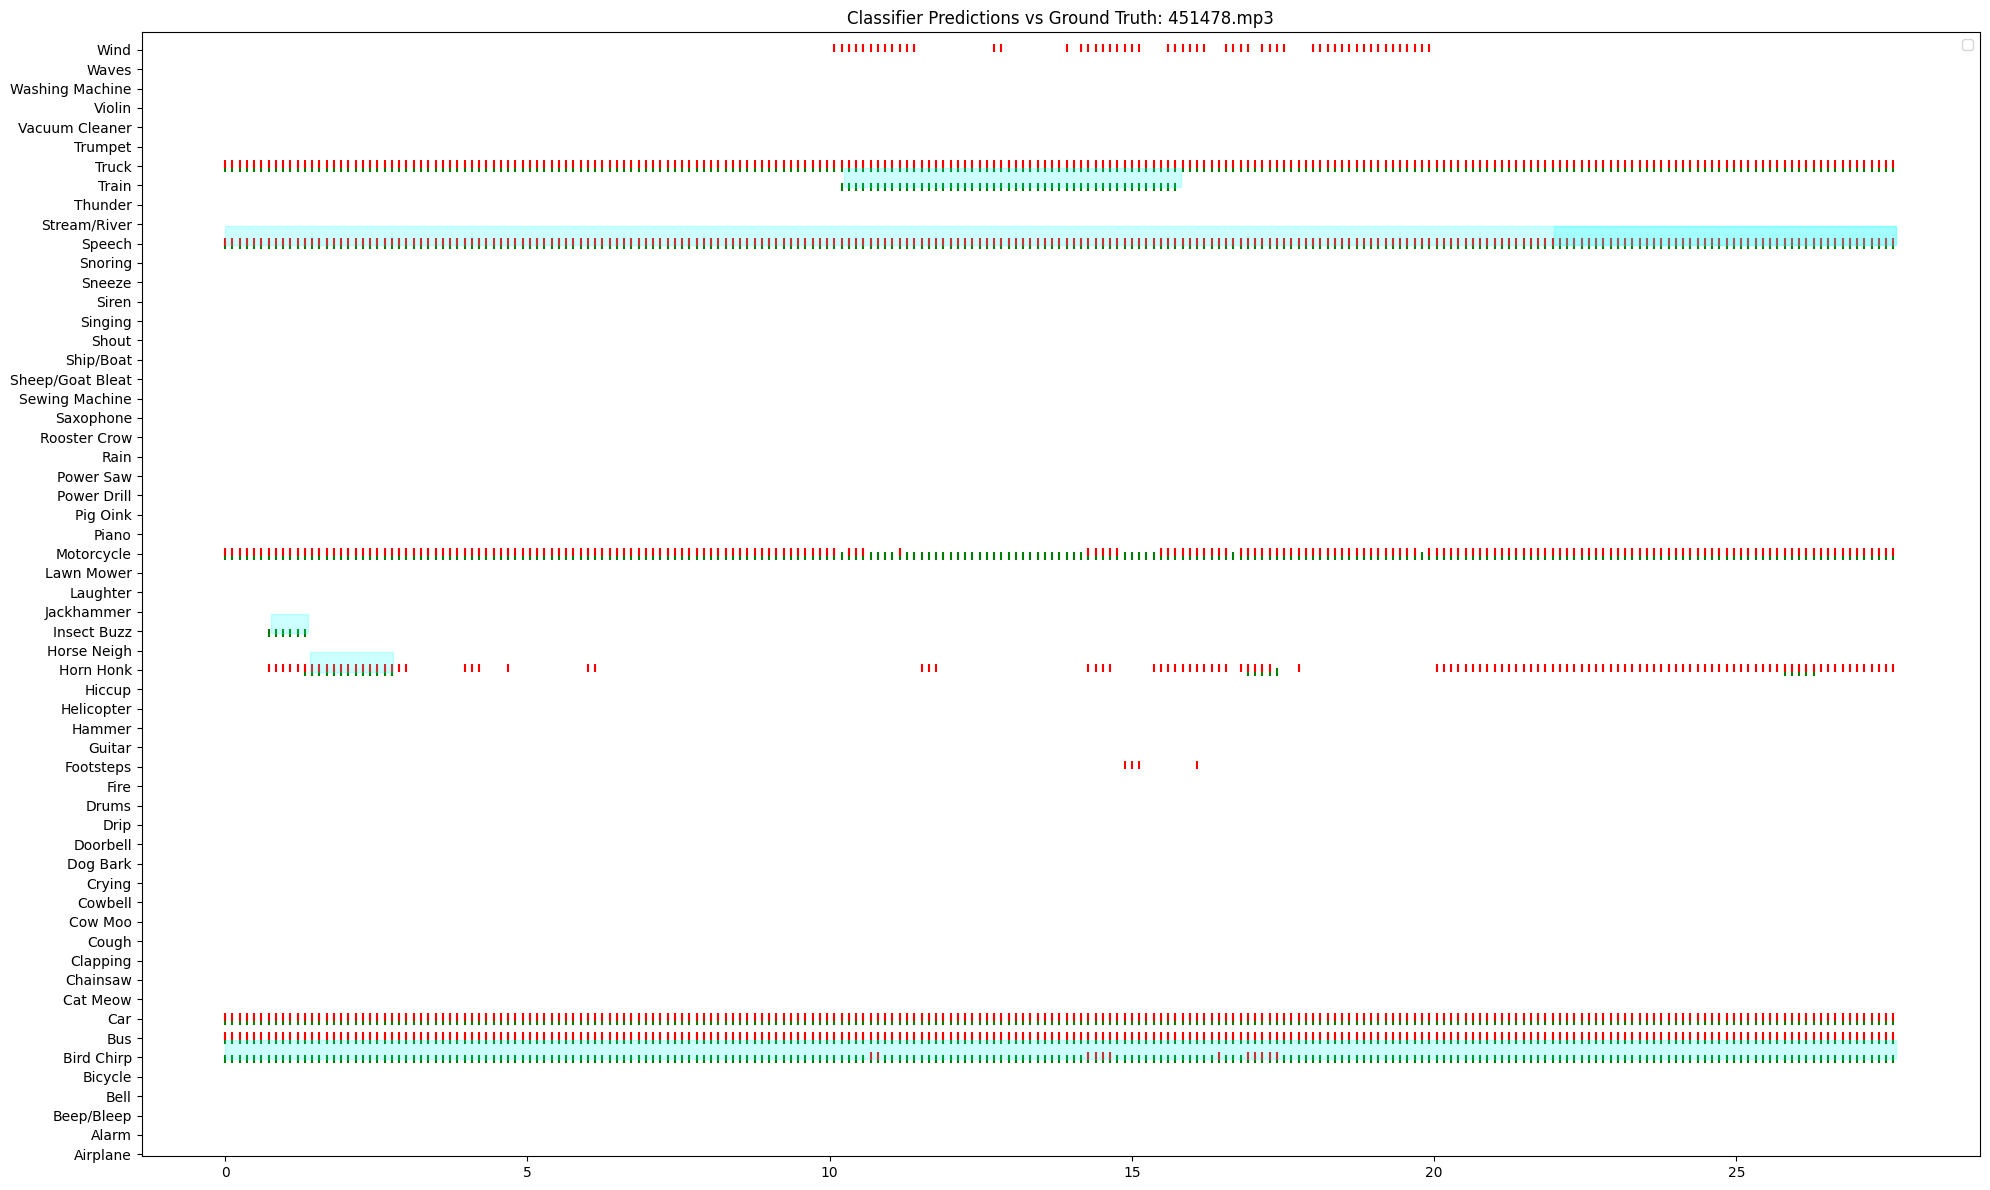

In [32]:
# Get model predictions for this file
file_features = np.load(os.path.join(features_dir, sample_file.replace('.mp3', '.npz')))["embeddings"]
file_features = scaler.transform(file_features)
file_features = pca.transform(file_features)

with torch.no_grad():
    inputs = torch.FloatTensor(file_features).to(device)
    outputs = model(inputs)
    predictions = torch.sigmoid(outputs).cpu().numpy() > 0.5

# Convert predictions to time segments (120ms per frame)
frame_duration = 0.12
total_frames = predictions.shape[0]
time_axis = np.arange(total_frames) * frame_duration

# Plot predictions and ground truth for each class
plt.figure(figsize=(20, 12))
plt.title(f'Classifier Predictions vs Ground Truth: {sample_file}')

for i, cls in enumerate(categories):
    # Ground truth
    label_path = os.path.join(DATA_DIR, 'labels', sample_file.replace('.mp3', '_labels.npz'))
    with np.load(label_path) as data:
        gt_frames = np.where(data[cls].mean(axis=1) > 0.5)[0]
    
    if len(gt_frames) > 0:
        gt_times = gt_frames * frame_duration
        plt.scatter(gt_times, [i*500]*len(gt_times), 
                   color='green', marker='|', label='Ground Truth' if i==0 else "")
    
    # Predictions
    pred_frames = np.where(predictions[:, i])[0]
    if len(pred_frames) > 0:
        pred_times = pred_frames * frame_duration
        plt.scatter(pred_times, [i*500 + 100]*len(pred_times), 
                   color='red', marker='|', label='Prediction' if i==0 else "")

# Add human annotations
file_annotations = annotations[annotations['filename'] == sample_file]
for _, row in file_annotations.iterrows():
    cls = row['categories'].strip("[]'")
    if cls in categories:
        idx = categories.index(cls)
        plt.axvspan(row['onset'], row['offset'], 
                   ymin=idx/len(categories), ymax=(idx+1)/len(categories),
                   color='cyan', alpha=0.2)

# Format plot
plt.yticks(
    np.arange(len(categories)) * 500 + 50,
    categories,
    rotation=0
)
plt.ylim(0, len(categories)*500)
plt.tight_layout()
plt.savefig(f'predictions_vs_truth_{sample_file}_most_label_classes.png')
plt.show()

#### Interpretation of the vizualization:

**Representation:**
- Ground truth labels (green ticks)
- Model predictions (red ticks)
- Human annotations (cyan shaded regions)

**Comparision:**
- Visualizes true positives (overlapping green/red)
- Shows false positives (red without green)
- Reveals false negatives (green without red)

**Model Errors:**
- Red ticks without green = false positives
- Green ticks without red = false negatives
- Systematic offsets = timing issues

**Ambiguous Cases:**
- Human annotations (cyan) without ground truth labels
- Disagreements between human annotators

#### Print annotations of least diverse label classes

In [33]:
# Print annotations of least diverse label classes
print("Print annotations of least diverse label classes")
print("=" * 80)

for sample_file in least_diverse_files.head(1)['filename']:
    file_to_play = os.path.join(DATA_DIR, "audio", sample_file)

    # print sample file name
    print(f"Playing '{sample_file}':")
    with np.load(os.path.join(DATA_DIR, 'labels', sample_file.replace('.mp3', '_labels.npz'))) as data:
        
        # print active classes in sample file
        active_classes = [cls for cls in data.keys() if data[cls].sum() > 0]
        print("Active classes:", sorted(set(active_classes)),"\n")

    # Load annotations 
    annotations = pd.read_csv(os.path.join(DATA_DIR, "annotations.csv"))

    # print annotations in sample file
    file_annotations = annotations[annotations['filename'] == sample_file].sort_values('onset')
    print(f"Number of annotations: {len(file_annotations)}")
    print(file_annotations[['onset', 'offset', 'text', 'categories']].head(len(file_annotations)))

Print annotations of least diverse label classes
Playing '668922.mp3':
Active classes: ['Speech'] 

Number of annotations: 11
           onset     offset  \
17198   0.000000   3.381737   
17189   0.024134   3.595961   
17190   3.692497  12.670332   
17199   3.954031   5.983073   
17193   6.329918   7.665270   
17194   8.202879  12.191595   
17191  12.694466  17.859135   
17195  12.937311  17.533005   
17192  18.197010  25.944000   
17196  18.417459  23.914949   
17197  24.313820  25.943991   

                                                    text  categories  
17198  A man with an American accent confidently spea...  ['Speech']  
17189                          A man is speaking calmly.  ['Speech']  
17190  A man is speaking with irregular pauses and fl...  ['Speech']  
17199  A man with an American accent confidently spea...  ['Speech']  
17193  A man with an American accent confidently spea...  ['Speech']  
17194  A man with an American accent confidently spea...  ['Speech']  
1719

#### Visualize the classifier's predictions

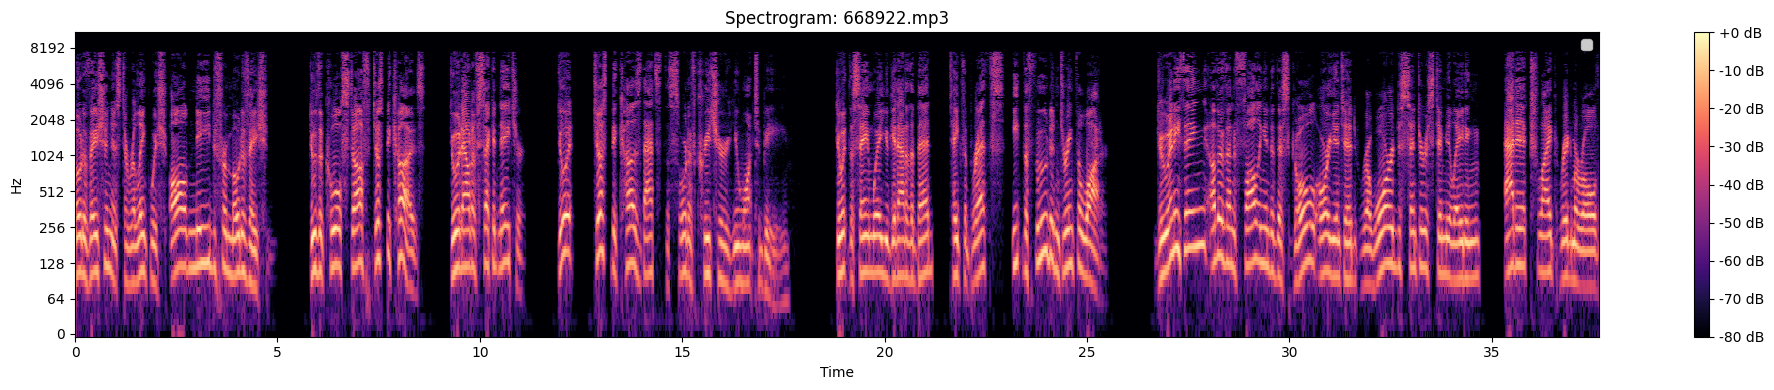

In [34]:
import librosa
import librosa.display

# Choose the least diverse file
sample_file = least_diverse_files['filename'].iloc[0]
file_to_play = os.path.join(DATA_DIR, "audio", sample_file)

# Load audio and create spectrogram
y, sr = librosa.load(file_to_play, sr=None)
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)

# Create figure
plt.figure(figsize=(20, 4))
librosa.display.specshow(D, y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Spectrogram: {sample_file}')
plt.tight_layout()
plt.savefig(f'spectrogram_{sample_file}_least_label_classes.png')
plt.show()

In [35]:
# Play audio with predictions
print("Playing full audio with prediction highlights:")
display(Audio(y, rate=sr, autoplay=False))

Playing full audio with prediction highlights:


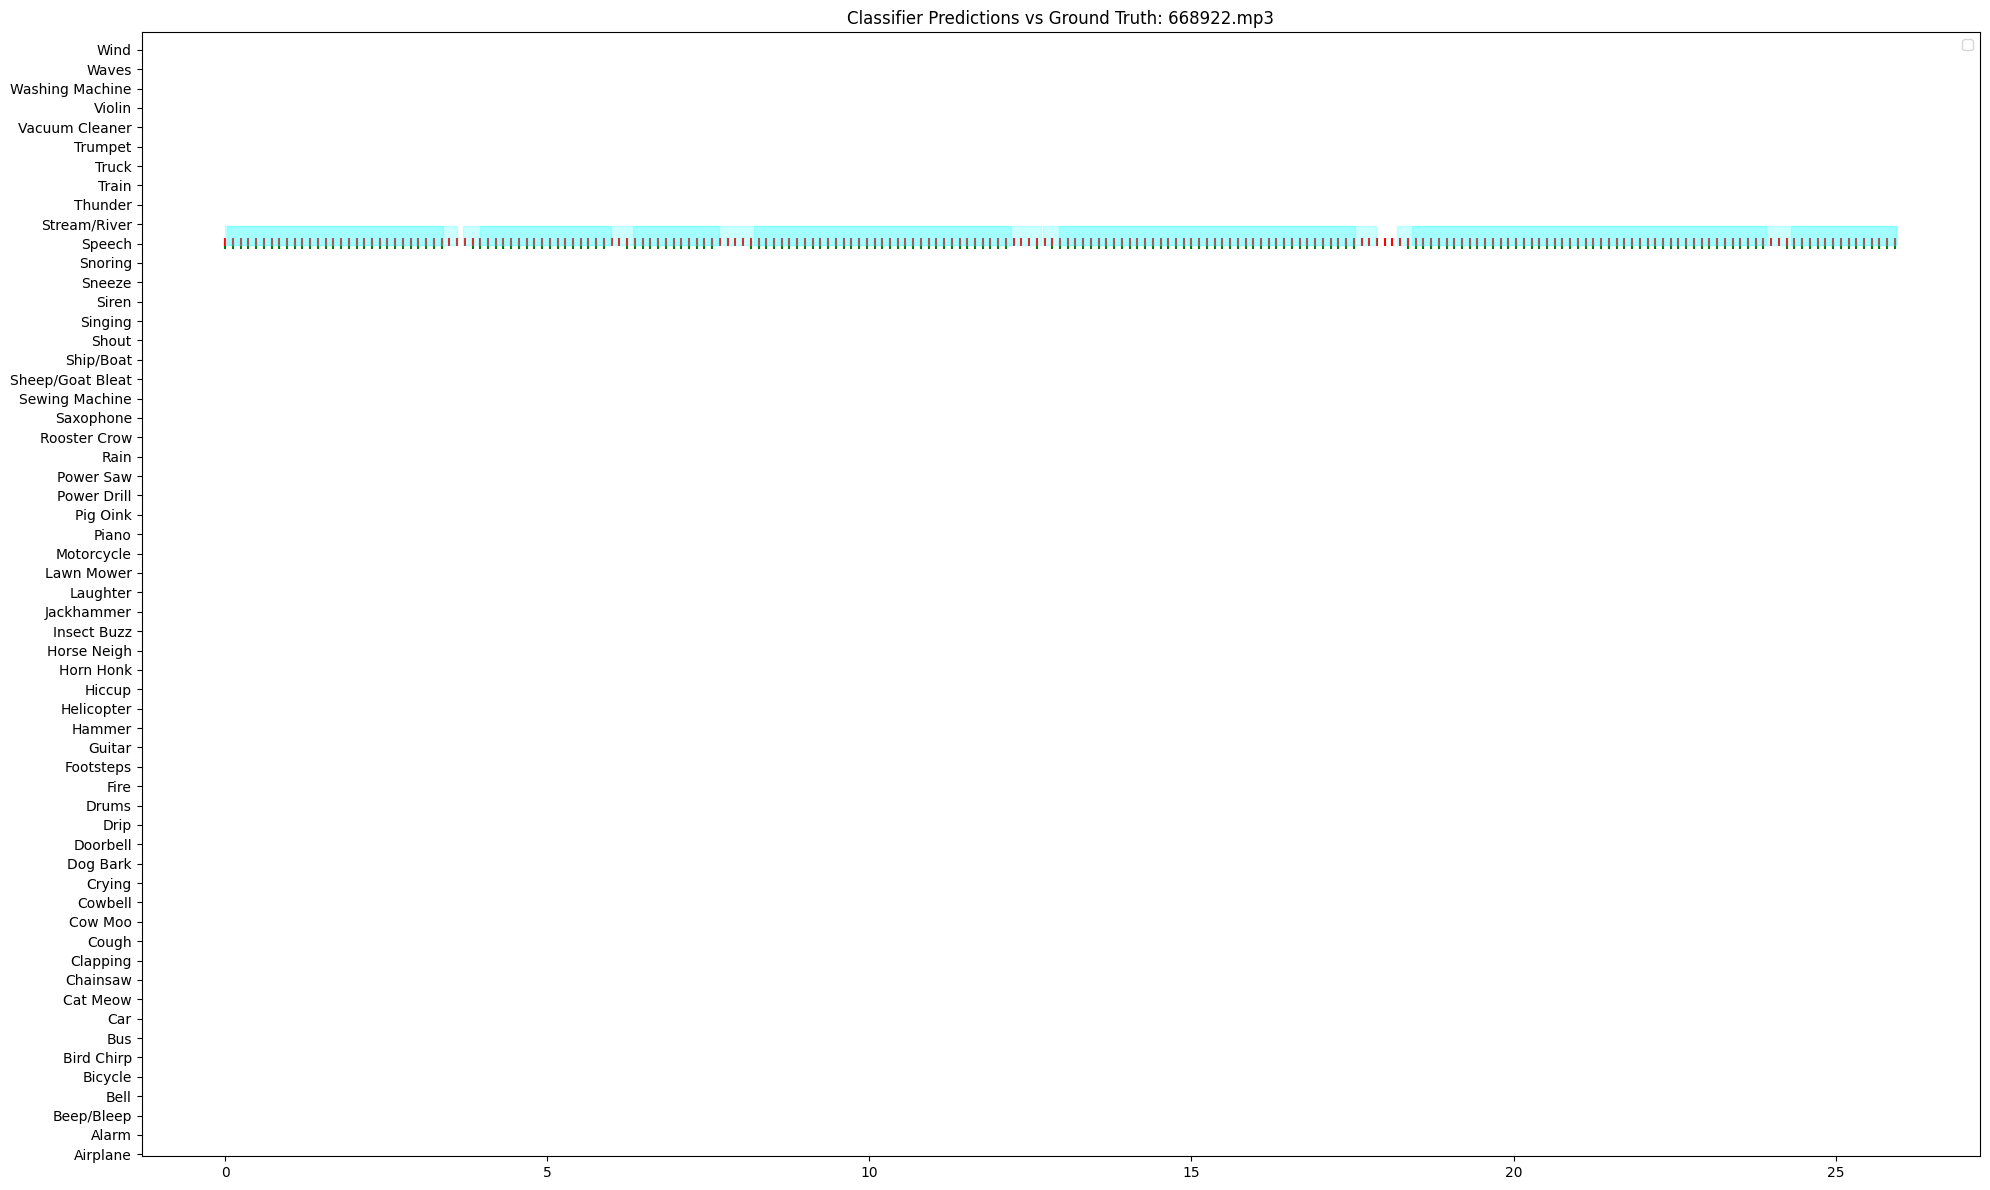

In [36]:
# Get model predictions for this file
file_features = np.load(os.path.join(features_dir, sample_file.replace('.mp3', '.npz')))["embeddings"]
file_features = scaler.transform(file_features)
file_features = pca.transform(file_features)

with torch.no_grad():
    inputs = torch.FloatTensor(file_features).to(device)
    outputs = model(inputs)
    predictions = torch.sigmoid(outputs).cpu().numpy() > 0.5

# Convert predictions to time segments (120ms per frame)
frame_duration = 0.12
total_frames = predictions.shape[0]
time_axis = np.arange(total_frames) * frame_duration

# Plot predictions and ground truth for each class
plt.figure(figsize=(20, 12))
plt.title(f'Classifier Predictions vs Ground Truth: {sample_file}')

for i, cls in enumerate(categories):
    # Ground truth
    label_path = os.path.join(DATA_DIR, 'labels', sample_file.replace('.mp3', '_labels.npz'))
    with np.load(label_path) as data:
        gt_frames = np.where(data[cls].mean(axis=1) > 0.5)[0]
    
    if len(gt_frames) > 0:
        gt_times = gt_frames * frame_duration
        plt.scatter(gt_times, [i*500]*len(gt_times), 
                   color='green', marker='|', label='Ground Truth' if i==0 else "")
    
    # Predictions
    pred_frames = np.where(predictions[:, i])[0]
    if len(pred_frames) > 0:
        pred_times = pred_frames * frame_duration
        plt.scatter(pred_times, [i*500 + 100]*len(pred_times), 
                   color='red', marker='|', label='Prediction' if i==0 else "")

# Add human annotations
file_annotations = annotations[annotations['filename'] == sample_file]
for _, row in file_annotations.iterrows():
    cls = row['categories'].strip("[]'")
    if cls in categories:
        idx = categories.index(cls)
        plt.axvspan(row['onset'], row['offset'], 
                   ymin=idx/len(categories), ymax=(idx+1)/len(categories),
                   color='cyan', alpha=0.2)

# Format plot
plt.yticks(
    np.arange(len(categories)) * 500 + 50,
    categories,
    rotation=0
)
plt.ylim(0, len(categories)*500)
plt.tight_layout()
plt.savefig(f'predictions_vs_truth_{sample_file}_least_label_classes.png')
plt.show()

**Representation:**
- Ground truth labels (green ticks)
- Model predictions (red ticks)
- Human annotations (cyan shaded regions)

**Comparision:**
- Visualizes true positives (overlapping green/red)
- Shows false positives (red without green)
- Reveals false negatives (green without red)

**Model Errors:**
- Red ticks without green = false positives
- Green ticks without red = false negatives
- Systematic offsets = timing issues

**Ambiguous Cases:**
- Human annotations (cyan) without ground truth labels
- Disagreements between human annotators